# 1. 数据加载和预处理

In [13]:
import re
import pandas as pd

texts = []  # 存储文本内容
labels = []  # 存储标签

with open(r'filtered_cnews.train.txt',  encoding='utf-8') as file:
    for line in file:
        # 去除首尾空白字符（如换行符）
        line = line.strip()
        if line:  # 确保非空行
            # 使用正则表达式提取标签和文本
            match = re.match(r'^(\S+)\s+(.*)', line)
            if match:
                label, text = match.groups()
                labels.append(label)
                texts.append(text)

# 查看数据基本信息
print(f"总样本数: {len(texts)}")
print(f"类别分布: {pd.Series(labels).value_counts()}")

总样本数: 30000
类别分布: 体育    5000
家居    5000
房产    5000
教育    5000
科技    5000
财经    5000
Name: count, dtype: int64


# 2. 数据划分

In [15]:
from sklearn.model_selection import train_test_split

# 划分训练集和临时集 (4000训练, 1000临时)
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

# 划分验证集和测试集 (各500)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")
print(f"测试集大小: {len(X_test)}")

训练集大小: 24000
验证集大小: 3000
测试集大小: 3000


# 3. 中文分词和特征提取

In [17]:
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer

def chinese_tokenizer(text):
    return list(jieba.cut(text))
# 使用TF-IDF提取特征
vectorizer = TfidfVectorizer(
    tokenizer=chinese_tokenizer,
    max_features=5000,  # 限制特征数量
    ngram_range=(1, 2),  # 包含unigram和bigram
    token_pattern=None
)
print("\n正在提取特征...")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
print(f"特征维度: {X_train_tfidf.shape[1]}")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\XXX\AppData\Local\Temp\jieba.cache



正在提取特征...


Loading model cost 1.876 seconds.
Prefix dict has been built successfully.


特征维度: 5000


# 4. 模型训练和评估（函数）

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置中文字体（使用系统支持的字体）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 常用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val):
    print(f"\n正在训练 {model_name}...")
    model.fit(X_train, y_train)
    
    # 在验证集上评估
    y_pred = model.predict(X_val)
    
    # 计算指标
    accuracy = accuracy_score(y_val, y_pred)
    # 添加 zero_division=0 避免除零警告
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    
    # 安全获取微平均和宏平均指标
    micro_avg = report.get('micro avg', {'f1-score': 0})
    macro_avg = report.get('macro avg', {'f1-score': 0})
    
    print(f"\n{model_name} 验证集准确率: {accuracy:.4f}")
    print("\n分类报告:")
    print(classification_report(y_val, y_pred, zero_division=0))
    
    # 混淆矩阵
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(labels),
                yticklabels=np.unique(labels))
    plt.title(f'{model_name} 混淆矩阵', fontproperties='SimHei', fontsize=14)
    plt.xlabel('预测标签', fontproperties='SimHei')
    plt.ylabel('真实标签', fontproperties='SimHei')
    plt.tight_layout()  # 防止标签被截断
    plt.show()
    
    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'micro_avg': micro_avg,
        'macro_avg': macro_avg,
        'confusion_matrix': cm
    }

## 4.1 朴素贝叶斯


正在训练 朴素贝叶斯...

朴素贝叶斯 验证集准确率: 0.9453

分类报告:
              precision    recall  f1-score   support

          体育       1.00      0.99      0.99       500
          家居       0.95      0.94      0.94       500
          房产       0.93      0.94      0.94       500
          教育       0.94      0.93      0.93       500
          科技       0.90      0.97      0.94       500
          财经       0.95      0.90      0.92       500

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



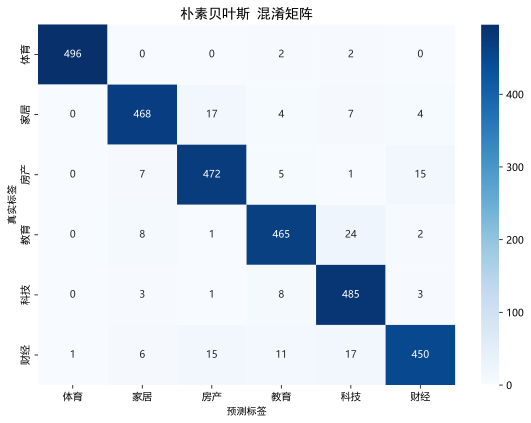

In [21]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_results = train_and_evaluate(nb_model, "朴素贝叶斯", 
                               X_train_tfidf, y_train, 
                               X_val_tfidf, y_val)

## 4.2 KNN


正在训练 KNN...

KNN 验证集准确率: 0.9270

分类报告:
              precision    recall  f1-score   support

          体育       0.99      0.99      0.99       500
          家居       0.95      0.91      0.93       500
          房产       0.90      0.92      0.91       500
          教育       0.90      0.92      0.91       500
          科技       0.90      0.92      0.91       500
          财经       0.93      0.91      0.92       500

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



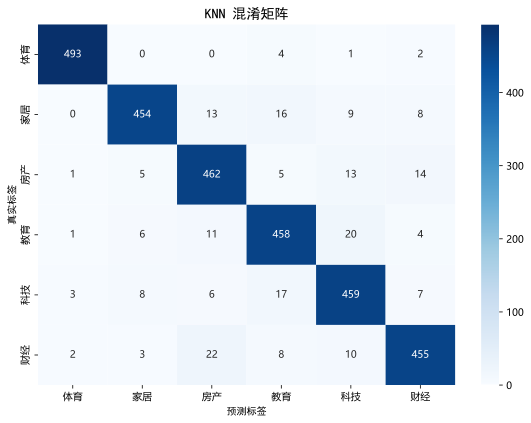

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_results = train_and_evaluate(knn_model, "KNN", 
                                X_train_tfidf, y_train, 
                                X_val_tfidf, y_val)

## 4.3 GBDT


正在训练 GBDT...

GBDT 验证集准确率: 0.9770

分类报告:
              precision    recall  f1-score   support

          体育       1.00      0.99      1.00       500
          家居       0.98      0.98      0.98       500
          房产       1.00      1.00      1.00       500
          教育       0.97      0.96      0.96       500
          科技       0.95      0.96      0.95       500
          财经       0.98      0.97      0.98       500

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



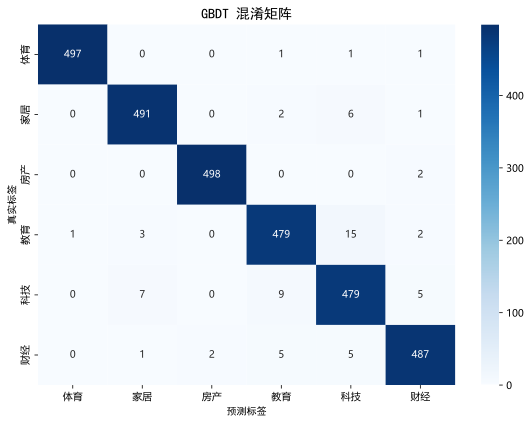

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbdt_results = train_and_evaluate(gbdt_model, "GBDT", 
                                 X_train_tfidf, y_train, 
                                 X_val_tfidf, y_val)

# 5. 模型比较和选择

In [40]:
results = [nb_results, knn_results, gbdt_results]

print("模型性能比较:")
comparison = pd.DataFrame({
    '模型': [r['name'] for r in results],
    '准确率': [r['accuracy'] for r in results],
    '微平均F1': [r['micro_avg']['f1-score'] for r in results],
    '宏平均F1': [r['macro_avg']['f1-score'] for r in results]
})
print(comparison)

# 选择最佳模型
best_model = gbdt_results['model']

模型性能比较:
      模型       准确率  微平均F1     宏平均F1
0  朴素贝叶斯  0.945333      0  0.945316
1    KNN  0.927000      0  0.927101
2   GBDT  0.977000      0  0.977020


# 6. 测试集评估最佳模型

在测试集上评估最佳模型 (GBDT)...
测试集分类报告:
              precision    recall  f1-score   support

          体育       1.00      1.00      1.00       500
          家居       0.97      0.97      0.97       500
          房产       1.00      1.00      1.00       500
          教育       0.95      0.94      0.94       500
          科技       0.95      0.94      0.95       500
          财经       0.96      0.98      0.97       500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



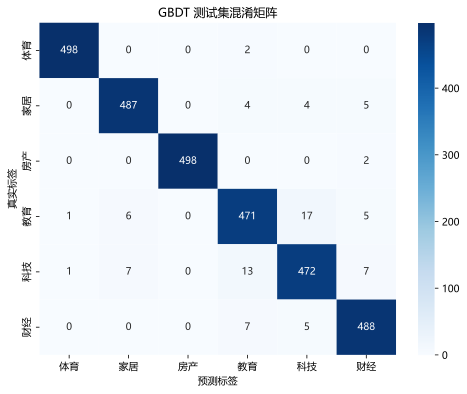

In [42]:
print("在测试集上评估最佳模型 (GBDT)...")
y_test_pred = best_model.predict(X_test_tfidf)

print("测试集分类报告:")
print(classification_report(y_test, y_test_pred))

# 测试集混淆矩阵
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(labels), 
            yticklabels=np.unique(labels))
plt.title('GBDT 测试集混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()